In [0]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d datamunge/sign-language-mnist

 93% 58.0M/62.6M [00:00<00:00, 27.8MB/s]
100% 62.6M/62.6M [00:00<00:00, 91.8MB/s]


In [3]:
!unzip sign-language-mnist.zip

Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from keras.layers import Input, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [0]:
def train_ml(X_train, y_train, X_test, y_test):

  print('-- Training LR --')
  lr = LogisticRegression(max_iter=2000, n_jobs=-1)
  lr.fit(X_train, y_train)
  y_pred = lr.predict(X_test)
  acc_lr = accuracy_score(y_test, y_pred)
  print('-- LR Trained --')

  print('-- Training SVC --')
  svc = SVC()
  svc.fit(X_train, y_train)
  y_pred_svc = svc.predict(X_test)
  acc_svc = accuracy_score(y_test, y_pred_svc)
  print('-- SVC Trained --')

  print('-- Training DTR --')
  dtr = DecisionTreeClassifier()
  dtr.fit(X_train, y_train)
  y_pred_dtr = dtr.predict(X_test)
  acc_dtr = accuracy_score(y_test, y_pred_dtr)
  print('-- DTR Trained --')

  print('-- Training RFR --')
  rfr = RandomForestClassifier(n_jobs=-1)
  rfr.fit(X_train, y_train)
  y_pred_rfr = rfr.predict(X_test)
  acc_rfr = accuracy_score(y_test, y_pred_rfr)
  print('-- RFR Trained --')

  pred = pd.DataFrame({'Model': ['LR', 'SVC', 'DTR', 'RFR'], 'Accuracy': [acc_lr, acc_svc, acc_dtr, acc_rfr]})

  return pred

In [0]:
def train_nn(X_train, y_train, X_test, y_test):

  i = Input(shape=(X_train.shape[1], ))
  x = Dropout(0.2)(i)
  x = Dense(units=512, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(units=256, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(units=128, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(units=64, activation='relu')(x)
  x = Dense(units=y_train.shape[1], activation='softmax')(x)

  model = Model(inputs=i, outputs=x)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

  return model, history

In [0]:
def train_cnn(X_train, y_train, X_test, y_test, datagen, l2_loss=None, epochs=50, batch_size=64):

  if l2_loss is None:
    l2_param = None
  else:
    l2_param = l2(l2_loss)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1)
  es = EarlyStopping(patience=10, verbose=1)

  i = Input(shape=(28, 28, 1))
  x = Convolution2D(64, input_shape=(28, 28, 1), kernel_size=(5, 5), activation='relu', kernel_regularizer=l2_param)(i)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  # x = Dropout(0.2)(x)
  x = Convolution2D(32, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2_param)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  # x = Dropout(0.2)(5, 5))
  x = Convolution2D(16, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2_param)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  # x = Dropout(0.2)(x)
  x = Convolution2D(8, kernel_size=(5, 5), activation='relu', padding='same', kernel_regularizer=l2_param)(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Flatten()(x)
  x = Dense(y_train.shape[1], activation='softmax')(x)
  model = Model(i, x)

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_test, y_test), callbacks=[reduce_lr, es])

  return model, history

In [0]:
def get_label(code):
  return chr(code+65)

In [0]:
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

In [0]:
X_train, y_train = train_df.iloc[:, 1:], train_df.iloc[:, 0]
X_test, y_test = test_df.iloc[:, 1:], test_df.iloc[:, 0]

<Figure size 432x288 with 0 Axes>

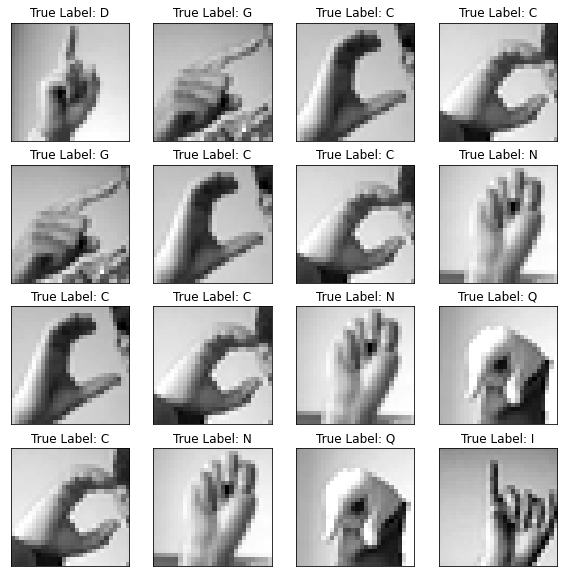

In [9]:
plt.figure()

f, axarr = plt.subplots(4, 4, figsize=(10, 10)) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.2)

for i in range(4):
  for j in range(4):
    fig = axarr[i][j].imshow(X_train.iloc[i+j, :].values.reshape(28, 28), cmap='gray')
    axarr[i][j].set_title('True Label: '+get_label(y_train[i+j]))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

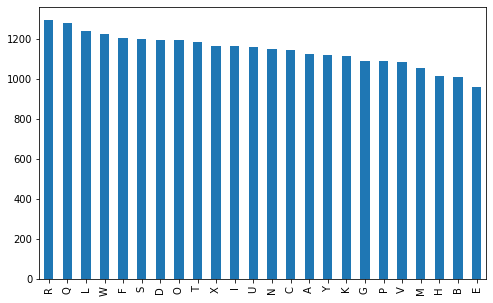

In [10]:
fig = y_train.apply(get_label).value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(8, 5))

In [0]:
X_train /= 255.
X_test /= 255.

In [0]:
pred = train_ml(X_train, y_train, X_test, y_test)
pred

-- Training LR --
-- LR Trained --
-- Training SVC --
-- SVC Trained --
-- Training DTR --
-- DTR Trained --
-- Training RFR --
-- RFR Trained --


,Model,Accuracy
0,LR,0.691718
1,SVC,0.841885
2,DTR,0.441021
3,RFR,0.811210


In [0]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

y_train = ohe.fit_transform(y_train.values.reshape(-1, 1))
y_test = ohe.transform(y_test.values.reshape(-1, 1))

In [13]:
y_train.shape

(27455, 24)

In [0]:
model, history = train_nn(X_train, y_train, X_test, y_test)

Train on 27455 samples, validate on 7172 samples
Epoch 1/100
27455/27455 [==============================] - 6s 213us/step - loss: 2.7493 - accuracy: 0.1410 - val_loss: 2.1235 - val_accuracy: 0.3105
Epoch 2/100
27455/27455 [==============================] - 6s 205us/step - loss: 2.0054 - accuracy: 0.3321 - val_loss: 1.6729 - val_accuracy: 0.4711
Epoch 3/100
27455/27455 [==============================] - 6s 206us/step - loss: 1.7629 - accuracy: 0.4087 - val_loss: 1.4280 - val_accuracy: 0.5353
Epoch 4/100
27455/27455 [==============================] - 6s 207us/step - loss: 1.5703 - accuracy: 0.4748 - val_loss: 1.2622 - val_accuracy: 0.5740
Epoch 5/100
27455/27455 [==============================] - 6s 207us/step - loss: 1.4441 - accuracy: 0.5140 - val_loss: 1.2285 - val_accuracy: 0.5605
Epoch 6/100
27455/27455 [==============================] - 6s 210us/step - loss: 1.3610 - accuracy: 0.5433 - val_loss: 1.1407 - val_accuracy: 0.5892
Epoch 7/100
27455/27455 [==============================] 

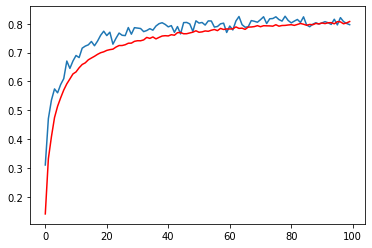

In [0]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'], color='red')

In [0]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [0]:
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1)

datagen.fit(X_train)

In [16]:
model_cnn, history_cnn = train_cnn(X_train, y_train.toarray(), X_test, y_test.toarray(), datagen, epochs=100, batch_size=64)

Epoch 1/100
429/429 [==============================] - 9s 21ms/step - loss: 2.6050 - accuracy: 0.1942 - val_loss: 1.5816 - val_accuracy: 0.4644
Epoch 2/100
429/429 [==============================] - 7s 17ms/step - loss: 1.3016 - accuracy: 0.5689 - val_loss: 0.7909 - val_accuracy: 0.7146
Epoch 3/100
429/429 [==============================] - 7s 17ms/step - loss: 0.7531 - accuracy: 0.7508 - val_loss: 0.4812 - val_accuracy: 0.8139
Epoch 4/100
429/429 [==============================] - 7s 17ms/step - loss: 0.5133 - accuracy: 0.8297 - val_loss: 0.3043 - val_accuracy: 0.8993
Epoch 5/100
429/429 [==============================] - 8s 18ms/step - loss: 0.3688 - accuracy: 0.8772 - val_loss: 0.2505 - val_accuracy: 0.9076
Epoch 6/100
429/429 [==============================] - 7s 17ms/step - loss: 0.2828 - accuracy: 0.9080 - val_loss: 0.1647 - val_accuracy: 0.9420
Epoch 7/100
429/429 [==============================] - 8s 18ms/step - loss: 0.2287 - accuracy: 0.9261 - val_loss: 0.1361 - val_accuracy:

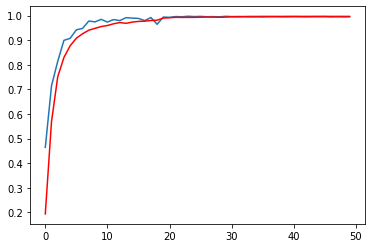

In [17]:
plt.plot(history_cnn.history['val_accuracy'])
plt.plot(history_cnn.history['accuracy'], color='red')